In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mpldts
import calendar
import netCDF4
import time

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse
import tensorflow as tf
import scipy as sp
from scikeras.wrappers import KerasRegressor
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import sklearn.metrics
import numpy as np
import pandas as pd
import os
import matlab.engine
import scipy.io
import math
import pdb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
import req_functions_modified
import importlib
import torch
import torch.nn as nn
import numpy as np
from data_prep import *
from lstm import *
from trainer import Optim
import time

plt.rcParams["font.family"] = "serif"   ## setting the font type for all the plots

In [3]:
import warnings

# Disable all warnings
warnings.filterwarnings('ignore')

In [4]:
### Marks the start time for the start of the predictor-corrector model (23rd March, 2024 at 11:30 pm)
start_time = 2330
buoy_num = '076'

### The same process has to be followed for all the ensemble members
num_members = 8

X_req = []

for k in range(1,num_members+1):
    ### The slow varying amplitudes computed using the model predictions through the wave model are read here.
    ### The initial model predictions are based on the WCSPH model simulations
    slow_vars = pd.read_csv(f"SlowVaryingAmplitudes_23_30_{k}.csv", header = None)
    elevation = np.transpose(np.asarray(pd.read_csv(f'Model_prediction_23_30_{k}.csv', header = None)))

    ### The observations from the buoy for a 5 minute window at this time are read here.
    observations = pd.read_csv('z_disp_23_30.txt', header = None)

    mse_error_window = []
    mae_error_window = []
    corr_window = []
    len_preds = len(elevation)
    len_observations = len(observations)
    for i in range(len_preds - len_observations + 1):
        obs = observations
        preds = elevation[i:len_observations+i]
        mse_error = mean_squared_error(np.array(obs).reshape(len_observations),np.array(preds).reshape(len_observations))
        mae_error = mean_absolute_error(np.array(obs).reshape(len_observations),np.array(preds).reshape(len_observations))
        corr = np.corrcoef(np.array(obs).reshape(len_observations),np.array(preds).reshape(len_observations))
        corr_score = corr[0,1]
        mse_error_window.append(mse_error)
        mae_error_window.append(mae_error)
        corr_window.append(corr_score)

    error_window = mse_error_window
    if error_window == corr_window:
        error = max(error_window)
    else:
        error = min(error_window)  
    error_index = error_window.index(error)

    slow_var_arrays = np.asarray(slow_vars)

    ### part of the model predictions to be used for comparing to the observations 
    slow_var_window = slow_var_arrays[:,error_index:len_observations+error_index] 

    X_req_23_30 = np.transpose(slow_var_window)
    Y_req_23_30 = np.asarray(observations)

    X_req.append(X_req_23_30)   ### x-data to be used for mapping to the buoy observations
    Y_req = Y_req_23_30   ### y-data to be used for the mapping (the observations)

X_req = np.asarray(X_req)

np.savetxt("model_data_X.csv", X_req.reshape(X_req.shape[0],-1), delimiter=",")
np.savetxt("model_data_X_shape.csv", X_req.shape, delimiter=",")
np.savetxt("observation_data_Y.csv", Y_req, delimiter=",")

In [5]:
### parameters used for the time series model
train_len = 20  ### training length of the time s'eries model
omegas = np.asarray(pd.read_csv("Omegas_23_30_Observations.csv", header=None)).T  ### frequencies of observations computed using the wave model

In [6]:
x_data = np.loadtxt('model_data_X.csv', delimiter=',')
x_data_shape = tuple(np.loadtxt('model_data_X_shape.csv', delimiter=',', dtype=int))

slow_vars_members = x_data.reshape(x_data_shape).tolist()

Forecasting done for the next observation window
Forecasting done for the next observation window
Forecasting done for the next observation window
Forecasting done for the next observation window
Time now is:2337
Forecasting done for the next observation window
Forecasting done for the next observation window
Forecasting done for the next observation window
Forecasting done for the next observation window
Time now is:2339
Forecasting done for the next observation window
Forecasting done for the next observation window
Forecasting done for the next observation window
Forecasting done for the next observation window
Time now is:2341
The elapsed time for running 5 minutes of the operation is 1 minutes and 4.73 seconds.


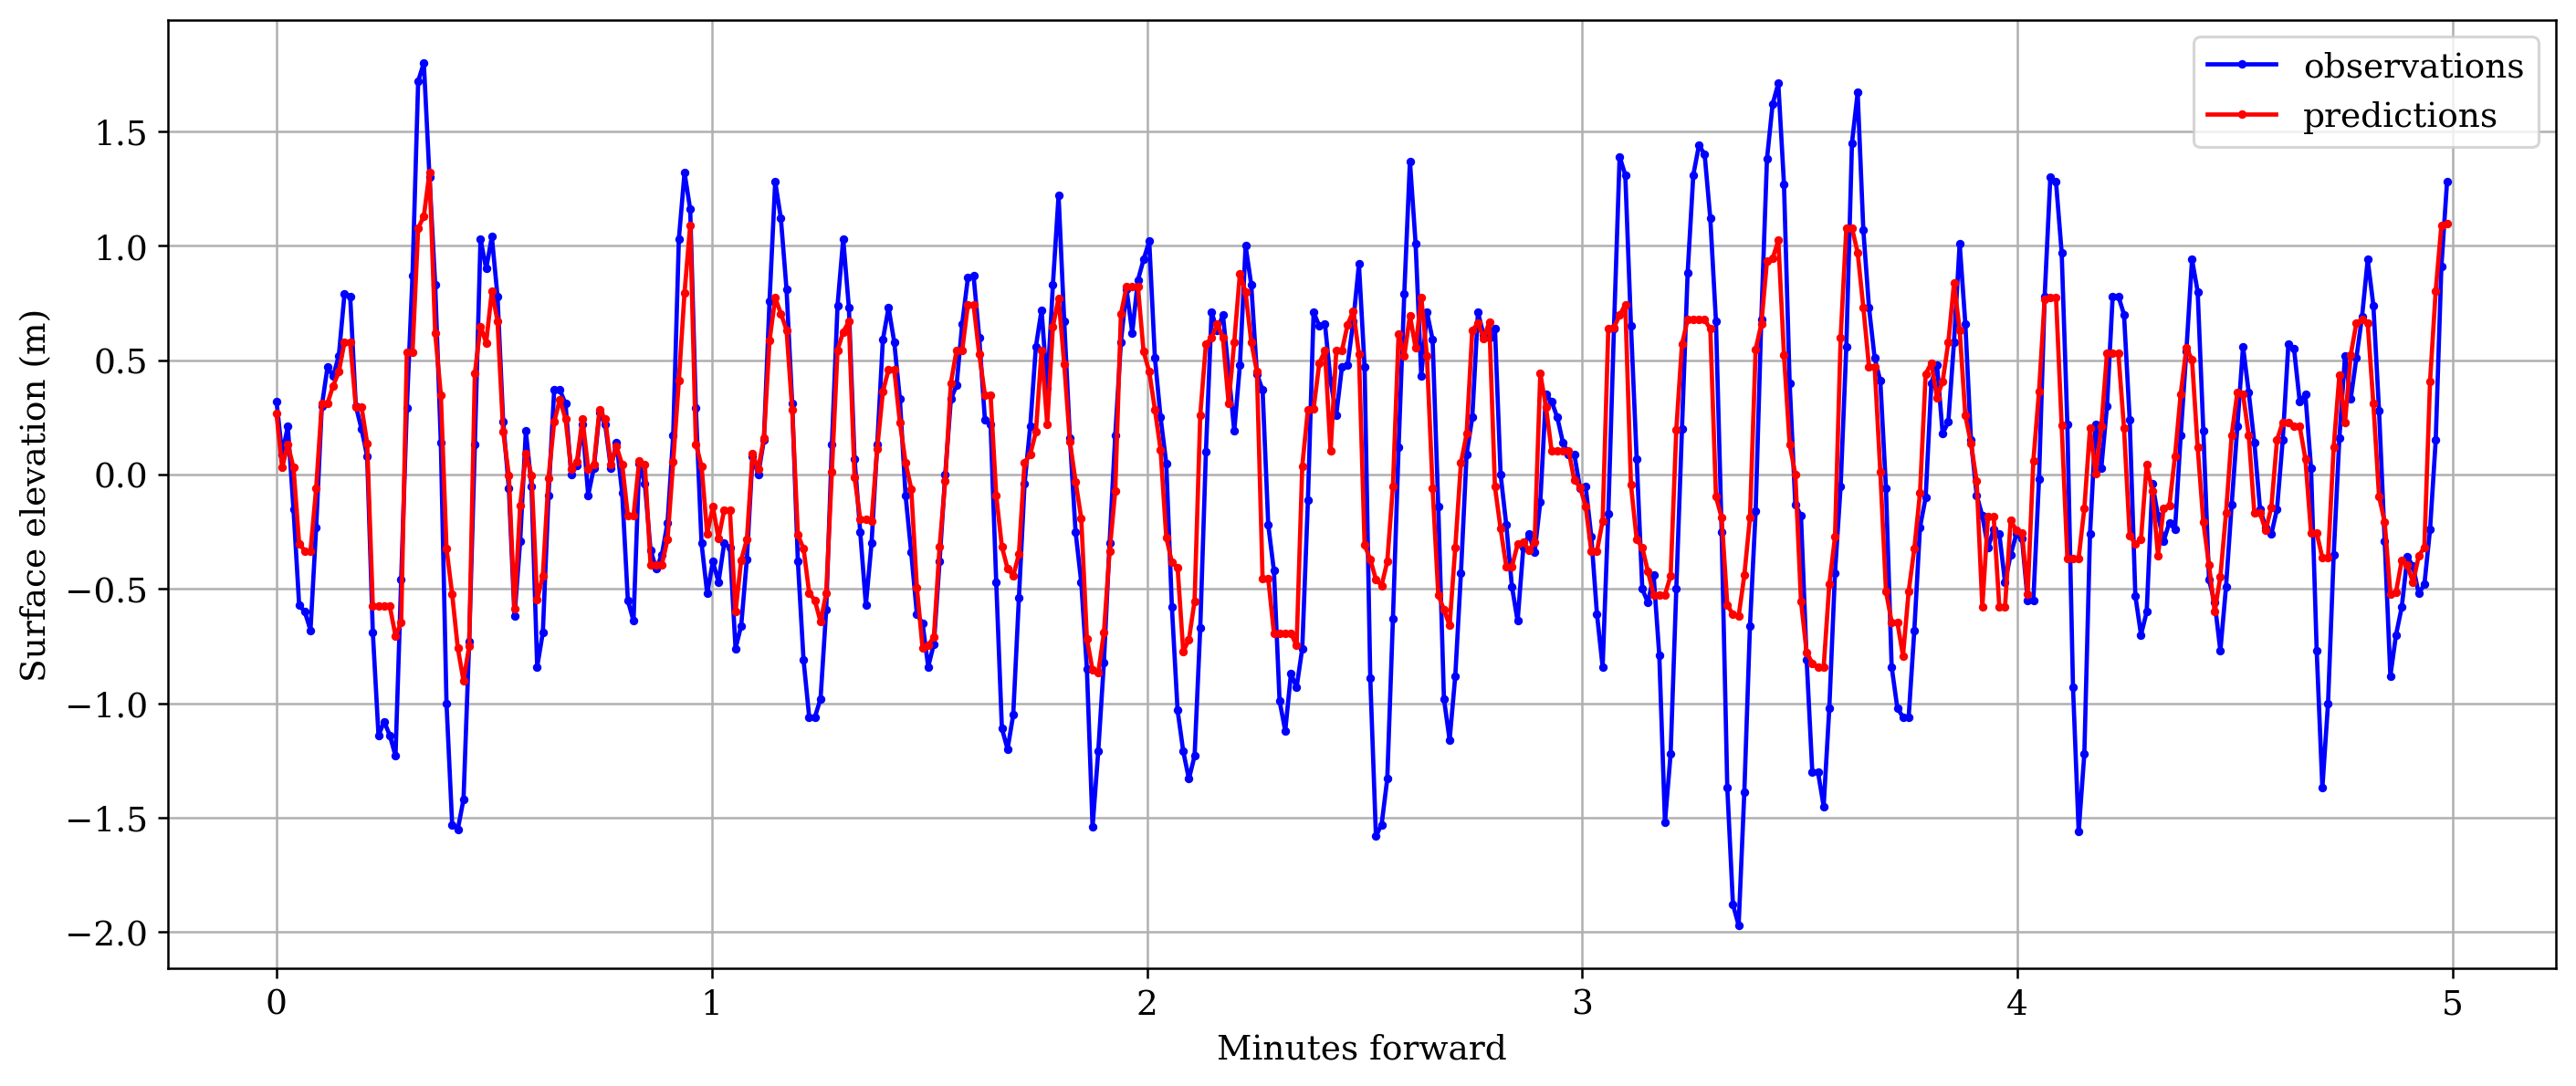

In [7]:
### Forecasting using the correction algorithm
### Incrementing the time till the required forecasting horizon
import time

#####
start_time = 2335 
### This is the time for the start of the time series prediction. The window from 23:30
### to 23:35 have been utilized for mapping the observations to the WCSPH model predictions
### and then for the training of the time series model.

start_operation = time.time()

device = 'cuda'
forecast_cumulative = []
# corrected_cumulative = []
observations_cumulative = []

num_mins = 5
forecast_horizon = start_time + num_mins

samplerate = 1.28
window_len_in_minutes = 2
window_len = int(samplerate * window_len_in_minutes * 60)
output_len = 15
increment = window_len_in_minutes
time_index = 0

while start_time < forecast_horizon:
    num_members = 4
    X_vars = []
    Y_vars = []
    forecast_members = []
    # corrected_members = []
    for k in range(num_members):
        slow_vars = np.asarray(slow_vars_members[k])
        # if k==0:
        #     print(slow_vars.shape)
        slow_amps_timeX = slow_vars.T[:,-train_len:]
        
        ### FORECASTING FOR THE NEXT WINDOW
        importlib.reload(req_functions_modified)
        # req_functions_modified.time_series_lstm_whole_latest(device, train_len, window_len, output_len, slow_amps_timeX, start_time)
        req_functions_modified.time_series_gnn_whole_latest(device, train_len, window_len, output_len, slow_amps_timeX, start_time)

        ### COMPARING THE FORECASTS AND THE OBSERVATIONS
        forecast_window = np.asarray(pd.read_csv(f"forecast_amps_next_window_train_len={train_len}", header=None))
        # print(forecast_window.shape)
        # t_model, t_obs, ele_corrected  = req_functions_modified.reconstructionElevation(forecast_window.T, omegas, 1, train_len)
        t_model, t_obs, ele_corrected  = req_functions_modified.reconstructionElevation(forecast_window.T, omegas, time_index, train_len)
        req_window = forecast_window.T[-train_len:,:]
        # print(req_window.shape)
        X_vars.append(req_window)
        # print(ele_corrected.shape)
        Y_vars.append(ele_corrected[-train_len:,:])

        forecast_members.append(ele_corrected) ### keeping track of the ensemble member forecasts

    time_index += window_len
    X_vars = np.asarray(X_vars)
    Y_vars = np.asarray(Y_vars)
    
    np.savetxt("x_space_results.csv", X_vars.reshape(X_vars.shape[0],-1), delimiter=",")
    np.savetxt("x_space_results_shape.csv", X_vars.shape, delimiter=",")
    np.savetxt("y_space_results.csv", Y_vars.reshape(Y_vars.shape[0],-1), delimiter=",")
    np.savetxt("y_space_results_shape.csv", Y_vars.shape, delimiter=",")
 
    time_str = str(start_time)
    time_obs = time_str[:2] + ":" + time_str[-2:]
    observations_new = req_functions_modified.buoy_observations(buoy_num, time_obs, increment)

    for p in range(num_members):
        elevations = forecast_members[p]
        for v in range(min(len(observations_new), len(elevations))):
            # print(f"v:{v}")
            obs_entry = observations_new[v]
            min_error = 100
            for s in range(max(v-5,0), min(v+5,len(elevations))):
                # print(f"s:{s}")
                error = abs(obs_entry - elevations[s])
                if error < min_error:
                    elevations[v] = elevations[s]
                    min_error = error

        forecast_members[p] = elevations
    
    forecast_mean = np.mean(np.asarray(forecast_members), axis = 0)
    forecast_cumulative.extend(forecast_mean) ### keeping track of the cumulative forecasts 
    # fore_cum = np.asarray(forecast_cumulative)
    # print(fore_cum.shape)
            
    # print(observations_new.shape)
    observations_cumulative.extend(observations_new) ### keeping track of the cumulative observations
    
    req_observations = observations_new[-train_len:]
    np.savetxt("buoy_obs.csv", np.asarray(req_observations), delimiter=",")
    
    # req_functions_modified.plot_reconstruction_observations(observations_new,ele_corrected,12,\
                                                            # "observations","forecasted elevation", start_time)
    
    #### CORRECTION OF THE AMPLITUDES USING PERTURBED OBSERVATIONS ENSEMBLE KALMAN FILTER
    Xa_mean, Xa_spread = req_functions_modified.LETKF("x_space_results.csv", "y_space_results.csv","x_space_results_shape.csv",
                                                      "y_space_results_shape.csv", "buoy_obs.csv")

    for k in range(num_members):
        req_window_corrected = np.zeros((req_window.shape))

        for i in range(req_window_corrected.shape[0]):
            # print(X_vars[k,i,:].shape)
            # print(obs.shape)
            # print(Y_vars[k,i,:].shape)
            # print(K[i].shape)
            
            arr_corrected = Xa_mean[i] + Xa_spread[i,:,k]
            # print(arr_corrected.shape)
            req_window_corrected[i,:] = arr_corrected
    
        ### USING THE CORRECTED AMPLITUDES AS THE STARTING POINT FOR THE NEXT CYCLE
        slow_amps_timeX = req_window_corrected
        # t_ana, t_ana, ele_corrected_ana  = req_functions_modified.reconstructionElevation(req_window_corrected, omegas, 1, train_len)
        # corrected_members.append(ele_corrected_ana) ### keeping track of the ensemble member forecasts
        
        slow_vars_members[k] = slow_amps_timeX
        observations = req_observations

    # corrected_cumulative.extend(corrected_members) ### keeping track of the cumulative forecasts
    
    start_time += increment
    if start_time%100 >= 60:
        start_time += 40
        forecast_horizon += 40
    
    print(f"Time now is:{start_time}")
    
    if (start_time > forecast_horizon):
        break

forecast_cumulative_mean = np.asarray(forecast_cumulative)
# corrected_cumulative_mean = np.mean(np.asarray(corrected_cumulative), axis=0)

forecast_horizon_len = int(samplerate * num_mins * 60)
forecast_cumulative_mean = forecast_cumulative_mean[:forecast_horizon_len]

# corrected_cumulative_mean = corrected_cumulative_mean[:forecast_horizon_len]
observations_cumulative = observations_cumulative[:forecast_horizon_len]

errors_cumulative = abs(np.asarray(observations_cumulative) - np.asarray(forecast_cumulative_mean))
# errors_corrected_cumulative = abs(np.asarray(observations_cumulative) - np.asarray(corrected_cumulative_mean))

# np.savetxt(f"LETKF_observations_using_GNN_full_duration_increment_{increment}_num_mins{num_mins}.csv", observations_cumulative, delimiter = "," )
# np.savetxt(f"LETKF_predictions_using_GNN_full_duration_increment_{increment}_num_mins{num_mins}.csv", forecast_cumulative_mean, delimiter = "," )
# np.savetxt(f"PoEnKF_corrected_predictions_full_duration_increment_{increment}_num_mins{num_mins}.csv", corrected_cumulative_mean, delimiter = "," )
np.savetxt(f"LETKF_errors_using_GNN_full_duration_increment_{increment}_num_mins{num_mins}_num_members_{num_members}_with_corrections.csv", errors_cumulative, delimiter = "," )
# np.savetxt(f"PoEnKF_corrected_errors_full_duration_increment_{increment}_num_mins{num_mins}.csv", errors_corrected_cumulative, delimiter = "," )

req_functions_modified.plot_complete_duration(observations_cumulative, forecast_cumulative_mean, num_mins, increment, \
                                              12,"observations","predictions", f'LETKF with corrections using  {num_members} ensemble members')
# req_functions_modified.plot_complete_duration(observations_cumulative, corrected_cumulative_mean, num_mins, increment, \
                                              # 12,"observations","corrected predictions", 'PoEnKF after correction')

end_operation = time.time()
elapsed_time = (end_operation - start_operation)
np.savetxt(f"LETKF_using_GNN_time_taken_full_duration_increment_{increment}_num_mins{num_mins}.csv", \
           np.asarray(elapsed_time).reshape(1), delimiter = "," )
print(f"The elapsed time for running {num_mins} minutes of the operation is {int(elapsed_time/60)} minutes and {round(elapsed_time%60,2)} seconds.")